In [ ]:
# Install LDM.
# !pip install -e .

In [1]:
import io
import os, sys

In [ ]:
sys.path.append('..')

In [ ]:
sys.path

In [1]:
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np
import yaml
from omegaconf import OmegaConf
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TVF
from IPython.display import display, display_markdown

from ldm.models.autoencoder import VQModelInterface, AutoencoderKL
from ldm.util import instantiate_from_config


torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x


def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x


def reconstruct_with_vqgan(x, model):
  with torch.no_grad():
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    print(x.shape, z.shape, indices.shape)
    print(indices)
    xrec = model.decode(z)
    return xrec


def reconstruct_with_autoencoder_kl(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  posterior = model.encode(x)
  # print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(posterior.sample()) 
  return xrec
  

def preprocess(img, target_image_size=256):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TVF.resize(img, s, interpolation=PIL.Image.Resampling.LANCZOS)
    img = TVF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img


## Using vq-f4 model

In [ ]:
config = OmegaConf.load(r"../models/first_stage_models/vq-f4/config.yaml")
pl_sd = torch.load(r"../models/first_stage_models/vq-f4/model.ckpt", map_location="cuda")
sd = pl_sd["state_dict"]
ldm_model = instantiate_from_config(config.model)
ldm_model.load_state_dict(sd, strict=False)

VQGAN --- VQModel: latent shape: torch.Size([96, 96])
torch.Size([1, 3, 384, 384]) torch.Size([1, 3, 96, 96]) torch.Size([9216])
tensor([1895, 5018,  771,  ..., 2997, 5181, 5940], device='cuda:0')


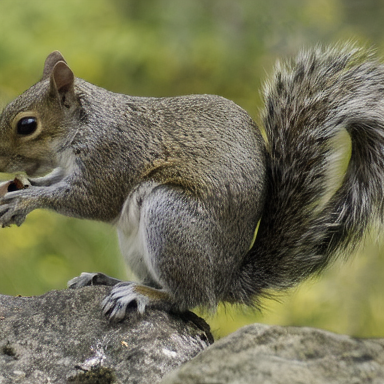

In [4]:
input_img=r"../logs/imgs/0810.png"


input_img = Image.open(input_img)
target_image_size = 384
# target_image_size = 512
x_vqgan = preprocess(input_img, target_image_size=target_image_size)
x_vqgan = x_vqgan.to(DEVICE)

# 4x spatial dimension reduction log_2(4) times divide h, w by 2.
ldm_model = ldm_model.to('cuda')

x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), ldm_model)
w, h = target_image_size, target_image_size

x0 = custom_to_pil(x0[0])
img = Image.new("RGB", (w, h))
img.paste(x0, (0,0))

display(img)

## Using kl-f4 model

In [5]:
config = OmegaConf.load(r"../models/first_stage_models/kl-f4/config.yaml")
pl_sd = torch.load(r"../models/first_stage_models/kl-f4/model.ckpt", map_location="cuda")
sd = pl_sd["state_dict"]
ldm_model = instantiate_from_config(config.model)
ldm_model.load_state_dict(sd, strict=False)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth


<All keys matched successfully>

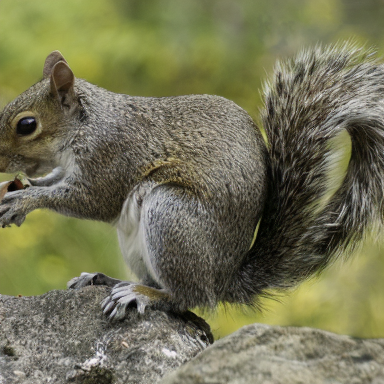

In [6]:
input_img=r"../logs/imgs/0810.png"


input_img = Image.open(input_img)
target_image_size = 384
# target_image_size = 512
x_vqgan = preprocess(input_img, target_image_size=target_image_size)
x_vqgan = x_vqgan.to(DEVICE)

# 4x spatial dimension reduction log_2(4) times divide h, w by 2.
ldm_model = ldm_model.to('cuda')

x0 = reconstruct_with_autoencoder_kl(preprocess_vqgan(x_vqgan), ldm_model)
w, h = target_image_size, target_image_size

x0 = custom_to_pil(x0[0])
img = Image.new("RGB", (w, h))
img.paste(x0, (0,0))

display(img)

## Using SD StabilityAI kl-f8 models

- https://huggingface.co/stabilityai/sd-vae-ft-ema-original/resolve/main/vae-ft-ema-560000-ema-pruned.ckpt
- https://huggingface.co/stabilityai/sd-vae-ft-mse-original/resolve/main/vae-ft-mse-840000-ema-pruned.ckpt

In [7]:
config = OmegaConf.load(r"../models/first_stage_models/kl-f8/config.yaml")
pl_sd = torch.load(r"../models/first_stage_models/kl-f8/vae-ft-mse-840000-ema-pruned.vae.ckpt", map_location="cuda")
sd = pl_sd["state_dict"]
ldm_model = instantiate_from_config(config.model)
ldm_model.load_state_dict(sd, strict=False)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth


_IncompatibleKeys(missing_keys=['loss.logvar', 'loss.perceptual_loss.scaling_layer.shift', 'loss.perceptual_loss.scaling_layer.scale', 'loss.perceptual_loss.net.slice1.0.weight', 'loss.perceptual_loss.net.slice1.0.bias', 'loss.perceptual_loss.net.slice1.2.weight', 'loss.perceptual_loss.net.slice1.2.bias', 'loss.perceptual_loss.net.slice2.5.weight', 'loss.perceptual_loss.net.slice2.5.bias', 'loss.perceptual_loss.net.slice2.7.weight', 'loss.perceptual_loss.net.slice2.7.bias', 'loss.perceptual_loss.net.slice3.10.weight', 'loss.perceptual_loss.net.slice3.10.bias', 'loss.perceptual_loss.net.slice3.12.weight', 'loss.perceptual_loss.net.slice3.12.bias', 'loss.perceptual_loss.net.slice3.14.weight', 'loss.perceptual_loss.net.slice3.14.bias', 'loss.perceptual_loss.net.slice4.17.weight', 'loss.perceptual_loss.net.slice4.17.bias', 'loss.perceptual_loss.net.slice4.19.weight', 'loss.perceptual_loss.net.slice4.19.bias', 'loss.perceptual_loss.net.slice4.21.weight', 'loss.perceptual_loss.net.slice4.21.

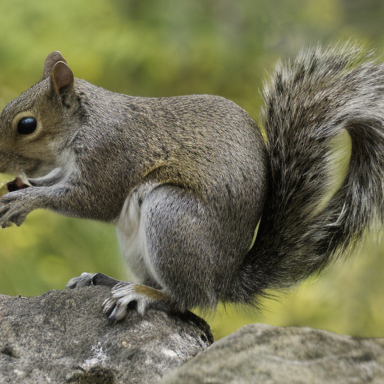

In [8]:
input_img=r"../logs/imgs/0810.png"


input_img = Image.open(input_img)
target_image_size = 384
# target_image_size = 512
x_vqgan = preprocess(input_img, target_image_size=target_image_size)
x_vqgan = x_vqgan.to(DEVICE)

# 8x spatial dimension reduction log_2(8) times divide h, w by 2.
ldm_model = ldm_model.to('cuda')

x0 = reconstruct_with_autoencoder_kl(preprocess_vqgan(x_vqgan), ldm_model)
w, h = target_image_size, target_image_size

x0 = custom_to_pil(x0[0])
img = Image.new("RGB", (w, h))
img.paste(x0, (0,0))

display(img)

In [9]:
config = OmegaConf.load(r"../models/first_stage_models/kl-f8/config.yaml")
pl_sd = torch.load(r"../models/first_stage_models/kl-f8/vae-ft-ema-560000-ema-pruned.vae.ckpt", map_location="cuda")
sd = pl_sd["state_dict"]
ldm_model = instantiate_from_config(config.model)
ldm_model.load_state_dict(sd, strict=False)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth


_IncompatibleKeys(missing_keys=['loss.logvar', 'loss.perceptual_loss.scaling_layer.shift', 'loss.perceptual_loss.scaling_layer.scale', 'loss.perceptual_loss.net.slice1.0.weight', 'loss.perceptual_loss.net.slice1.0.bias', 'loss.perceptual_loss.net.slice1.2.weight', 'loss.perceptual_loss.net.slice1.2.bias', 'loss.perceptual_loss.net.slice2.5.weight', 'loss.perceptual_loss.net.slice2.5.bias', 'loss.perceptual_loss.net.slice2.7.weight', 'loss.perceptual_loss.net.slice2.7.bias', 'loss.perceptual_loss.net.slice3.10.weight', 'loss.perceptual_loss.net.slice3.10.bias', 'loss.perceptual_loss.net.slice3.12.weight', 'loss.perceptual_loss.net.slice3.12.bias', 'loss.perceptual_loss.net.slice3.14.weight', 'loss.perceptual_loss.net.slice3.14.bias', 'loss.perceptual_loss.net.slice4.17.weight', 'loss.perceptual_loss.net.slice4.17.bias', 'loss.perceptual_loss.net.slice4.19.weight', 'loss.perceptual_loss.net.slice4.19.bias', 'loss.perceptual_loss.net.slice4.21.weight', 'loss.perceptual_loss.net.slice4.21.

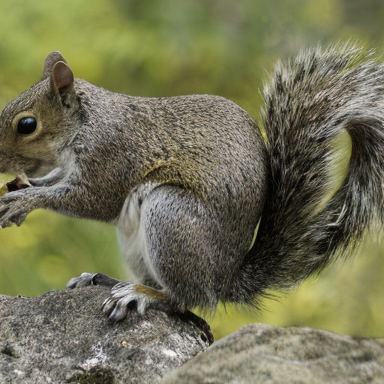

In [10]:
input_img=r"../logs/imgs/0810.png"


input_img = Image.open(input_img)
target_image_size = 384
# target_image_size = 512
x_vqgan = preprocess(input_img, target_image_size=target_image_size)
x_vqgan = x_vqgan.to(DEVICE)

# 8x spatial dimension reduction log_2(8) times divide h, w by 2.
ldm_model = ldm_model.to('cuda')

x0 = reconstruct_with_autoencoder_kl(preprocess_vqgan(x_vqgan), ldm_model)
w, h = target_image_size, target_image_size

x0 = custom_to_pil(x0[0])
img = Image.new("RGB", (w, h))
img.paste(x0, (0,0))

display(img)